# Experiments and Backtests on the Algorithms

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import mlfinlab
from agents import Static
from satis_models import sharpe_ratio
from environment import StaticEnvironment
from mom_models import sample_cov, mean_return_historic, ema_return_historic, elton_gruber_cov
from factor_models import linear_factor_mod
import pandas_datareader as web
import cvxpy as cp
from finrl.config import config

from scipy.optimize import minimize

from pandas.tseries.offsets import BDay
%load_ext autoreload

In [2]:
DB_PATH = 'C:/Users/matus/gdrive/datasets/Research/'
DB_PATH_TEMP = 'C:/Users/matus/Infinity Capital Strategies/3_Market Intelligence/1_Quant Research/temp_DB/Research/old/'
DB_PATH_NEW = 'C:/Users/matus/Infinity Capital Strategies/3_Market Intelligence/1_Quant Research/temp_DB/Research/'

In [3]:
#djia dataset
df = pd.read_csv(DB_PATH + '00_db_SPX_MOM50__PX_LAST.csv', index_col = 0)
# df = df.pivot(index='date',columns='tic')['close']
df.index = pd.to_datetime(df.index)
returns = df.pct_change().dropna()
returns = returns.loc['2019-01-01':]
returns = returns.iloc[:-1,:]

In [4]:
db_factors = pd.read_excel(DB_PATH + '00_db_FACTORS__PX_LAST.xlsx', index_col = 0, parse_dates = True)
# db_factors = db_factors.dropna().resample('M').ffill()
db_factors = db_factors.pct_change()
db_sectors = pd.read_excel(DB_PATH_TEMP + '00_db_sectors_temp.xlsx', index_col = 0, parse_dates = True)
# db_sectors = db_sectors.resample('M').ffill()
db_sectors = db_sectors.pct_change()

In [5]:
db_factors = db_factors.loc[returns.index]
db_sectors = db_sectors.loc[returns.index]

In [6]:
Agent = Static(mean_return_historic, sample_cov, len(df.columns),allow_short=False)

In [7]:
w_opt_qu = Agent.act(returns, optimization_problem = 'max_sharpe')
w_opt_mv = Agent.act(returns, optimization_problem = 'minimum_variance')
w_opt_ev = Agent.act(returns, optimization_problem = 'equal_weights')
Agent.set_factor_bound(0.3)
w_opt_fc = Agent.act(returns, optimization_problem = 'sr_factor', factors = db_sectors)
w_opt_er = Agent.act(returns, optimization_problem = 'equal_risk')

In [8]:
res = pd.DataFrame({'max_sharpe': w_opt_qu,
                   'minimum_variance': w_opt_mv,
                   'equal_weight': w_opt_ev.flatten(),
                   'factor_sr': w_opt_fc,
                   'equal_risk': w_opt_er}, index = df.columns)

<AxesSubplot:>

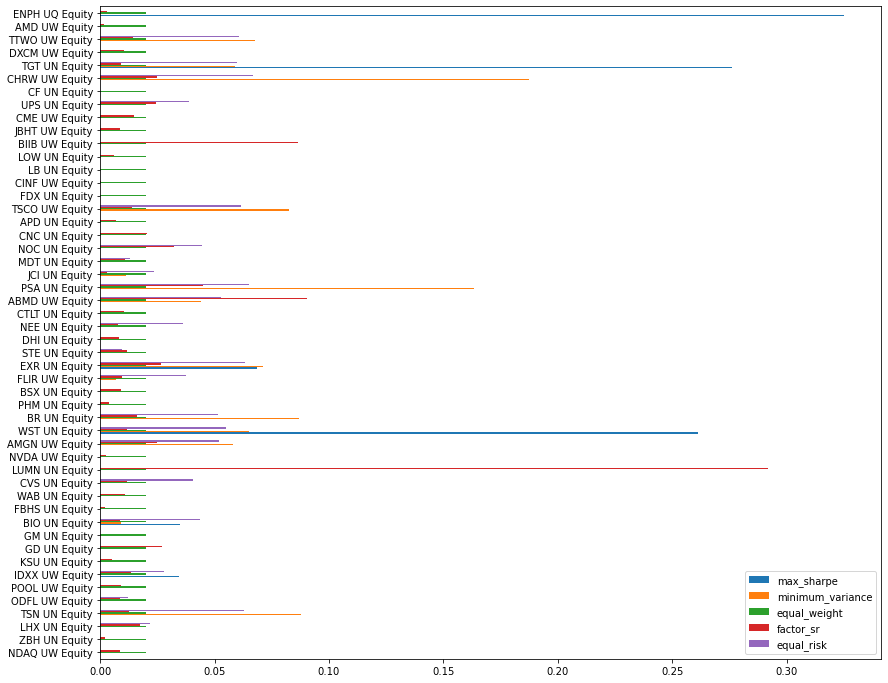

In [9]:
res.plot(kind='barh', figsize=(14,12))

In [10]:
beta, u = linear_factor_mod(returns*100, db_factors*100, regularize = 'net')

In [11]:
loadings = pd.DataFrame(beta,columns = db_factors.columns, index = df.columns)

In [12]:
loadings.sort_values(by='PVALUEUS Index')

,PVALUEUS Index,PMOMENUS Index,PSIZEUS Index,SPX Index
LB UN Equity,-2.221906,-0.390433,0.714991,0.269188
TSN UN Equity,-1.745029,-0.244492,-1.686106,0.218999
FDX UN Equity,-1.334682,0.244508,-0.525879,0.431231
LOW UN Equity,-1.299099,0.022380,-1.280832,0.296936
CTLT UN Equity,-1.186578,-0.024379,-2.153904,0.366237
ENPH UQ Equity,-1.075706,-0.601707,-0.199171,0.235857
CF UN Equity,-1.042757,0.337223,-0.245666,0.351549
WAB UN Equity,-1.020123,0.732521,-1.712366,0.170680
ZBH UN Equity,-0.934778,-0.206284,0.237367,0.173344
DHI UN Equity,-0.864674,-0.491085,0.425660,0.180587


In [14]:
mu = mean_return_historic(returns)
sigma = sample_cov(returns)

In [ ]:
D = np.diag(np.diag(sigma))

In [15]:
np.cov(beta,rowvar=False).shape

(4, 4)

In [16]:
w = cp.Variable(D.shape[0])
f = beta.T@w
gamma = cp.Parameter(nonneg=True)
ret = mu.T@w
risk = cp.quad_form(f, np.cov(beta,rowvar=False)) + cp.quad_form(w, D)
constraints = [cp.sum(w) == 1,
               w <= 1,
               w >= 0,
               f <= 0.3]

prob_factor = cp.Problem(cp.Minimize(gamma*risk - ret), 
                         constraints)
gamma.value = 2.
prob_factor.solve(verbose=True)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 54, constraints m = 109
          nnz(P) + nnz(A) = 598
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.0819e-02   1.00e+00   2.12e+03   1.00e-01   1.63e-04s
  50   1.9529e+00   1.70e-10   1.00e-08   1.00e-01   3.17e-04s
plsh   1.9529e+00   1.68e-16   5.93e-15   ----

1.9529190597285546

<AxesSubplot:>

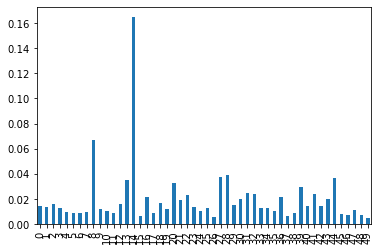

In [17]:
pd.Series(w.value).plot(kind='bar')

In [18]:
from agents import _quad_factor_model

## Equal vol contribution 

## scipy optimize 

In [19]:
from scipy.optimize import minimize

In [20]:
def calculate_portfolio_var(w, V):
    w = np.matrix(w)
    sigma = w*V*w.T
    return sigma[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0] # covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x


b = np.ones((1, mu.shape[0]))
b = b / mu.shape[0] # your risk budget percent of total portfolio risk (equal risk)
cons = ({'type': 'eq', 'fun': total_weight_constraint},
{'type': 'ineq', 'fun': long_only_constraint})
res= minimize(risk_budget_objective, b, args=[sigma,b], method='SLSQP',constraints=cons, options={'disp': True})
w_rb = np.asmatrix(res.x)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0628501279771745e-06
            Iterations: 6
            Function evaluations: 307
            Gradient evaluations: 6


<AxesSubplot:>

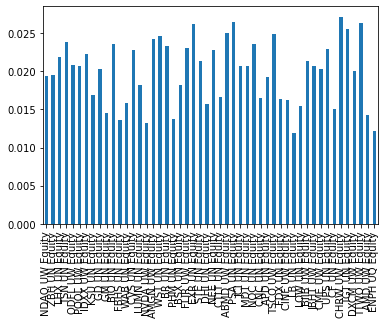

In [21]:
pd.Series(np.array(w_rb).reshape(mu.shape[0],), index = returns.columns).plot(kind = 'bar')

### cvxpy

In [22]:
mu = mean_return_historic(returns)
sigma = sample_cov(returns)

In [23]:
g = cp.Variable(nonneg=True)
b = np.ones((1, mu.shape[0]))
b = b / mu.shape[0]
w = cp.Variable((mu.shape[0], 1))
n = mu.shape[0]
G = scipy.linalg.sqrtm(sigma)
constraints = [cp.SOC(g, G.T @ w)]
risk1 = g ** 2

NameError: name 'scipy' is not defined

In [ ]:
obj = cp.Minimize(risk1)
constraints += [b @ cp.log(w)  >= 1 , w >= 0]

In [ ]:
problem = cp.Problem(obj, constraints)


In [ ]:
problem.solve(verbose = True)

In [ ]:
weights = np.array(w.value, ndmin = 2).T